In [37]:
import pymc3 as pm
import scipy.stats as stats
from IPython.core.pylabtools import figsize

# How to order Reddit submissions

You may have disagreed with the original statement that the Law of Large numbers is known to everyone, but only implicitly in our subconscious decision making. Consider ratings on online products: how often do you trust an average 5-star rating if there is only 1 reviewer? 2 reviewers? 3 reviewers? We implicitly understand that with such few reviewers that the average rating is **not** a good reflection of the true value of the product.

This has created flaws in how we sort items, and more generally, how we compare items. Many people have realized that sorting online search results by their rating, whether the objects be books, videos, or online comments, return poor results. Often the seemingly top videos or comments have perfect ratings only from a few enthusiastic fans, and truly more quality videos or comments are hidden in later pages with *falsely-substandard* ratings of around 4.8. How can we correct this?

Consider the popular site Reddit. The site hosts links to stories or images, called submissions, for people to comment on. Redditors can vote up or down on each submission (called upvotes and downvotes). Reddit, by default, will sort submissions to a given subreddit by Hot, that is, the submissions that have the most upvotes recently.

<img src="http://i.imgur.com/3v6bz9f.png" />


How would you determine which submissions are the best? There are a number of ways to achieve this:

1. *Popularity*: A submission is considered good if it has many upvotes. A problem with this model is that a submission with hundreds of upvotes, but thousands of downvotes. While being very *popular*, the submission is likely more controversial than best.
2. *Difference*: Using the *difference* of upvotes and downvotes. This solves the above problem, but fails when we consider the temporal nature of submission. Depending on when a submission is posted, the website may be experiencing high or low traffic. The difference method will bias the *Top* submissions to be the those made during high traffic periods, which have accumulated more upvotes than submissions that were not so graced, but are not necessarily the best.
3. *Time adjusted*:  Consider using Difference divided by the age of the submission. This creates a *rate*, something like *difference per second*, or *per minute*. An immediate counter-example is, if we use per second, a 1 second old submission with 1 upvote would be better than a 100 second old submission with 99 upvotes. One can avoid this by only considering at least t second old submission. But what is a good t value? Does this mean no submission younger than t is good? We end up comparing unstable quantities with stable quantities (young vs. old submissions).
3. *Ratio*: Rank submissions by the ratio of upvotes to total number of votes (upvotes plus downvotes). This solves the temporal issue, such that new submissions who score well can be considered Top just as likely as older submissions, provided they have many upvotes to total votes. The problem here is that a submission with a single upvote (ratio = 1.0) will beat a submission with 999 upvotes and 1 downvote (ratio = 0.999), but clearly the latter submission is *more likely* to be better.

I used the phrase *more likely* for good reason. It is possible that the former submission, with a single upvote, is in fact a better submission than the later with 999 upvotes. The hesitation to agree with this is because we have not seen the other 999 potential votes the former submission might get. Perhaps it will achieve an additional 999 upvotes and 0 downvotes and be considered better than the latter, though not likely.

What we really want is an estimate of the *true upvote ratio*. Note that the true upvote ratio is not the same as the observed upvote ratio: the true upvote ratio is hidden, and we only observe upvotes vs. downvotes (one can think of the true upvote ratio as "what is the underlying probability someone gives this submission a upvote, versus a downvote"). So the 999 upvote / 1 downvote submission probably has a true upvote ratio close to 1, which we can assert with confidence thanks to the Law of Large Numbers, but on the other hand we are much less certain about the true upvote ratio of the submission with only a single upvote. Sounds like a Bayesian problem to me.

One way to determine a prior on the upvote ratio is to look at the historical distribution of upvote ratios. This can be accomplished by scraping Reddit's submissions and determining a distribution. There are a few problems with this technique though:

1. Skewed data:  The vast majority of submissions have very few votes, hence there will be many submissions with ratios near the extremes, effectively skewing our distribution to the extremes. One could try to only use submissions with votes greater than some threshold. Again, problems are encountered. There is a tradeoff between number of submissions available to use and a higher threshold with associated ratio precision. 
2. Biased data: Reddit is composed of different subpages, called subreddits. Two examples are *r/aww*, which posts pics of cute animals, and *r/politics*. It is very likely that the user behaviour towards submissions of these two subreddits are very different: visitors are likely friendly and affectionate in the former, and would therefore upvote submissions more, compared to the latter, where submissions are likely to be controversial and disagreed upon. Therefore not all submissions are the same. 


In light of these, I think it is better to use a `Uniform` prior.


With our prior in place, we can find the posterior of the true upvote ratio. The Python script `top_showerthoughts_submissions.py` will scrape the best posts from the `showerthoughts` community on Reddit. This is a text-only community so the title of each post *is* the post. Below is the top post as well as some other sample posts:

In [6]:
#adding a number to the end of the %run call will get the ith top post.
%run ../utils/top_showerthoughts_submissions.py 2

print(f'Post contents: \n{top_post}')

Post contents: 

When you're a kid, you don't realize you're also watching your mom and dad grow up.


In [13]:
"""
contents: an array of the text from the last 100 top submissions to a subreddit
votes: a 2d numpy array of upvotes, downvotes for each submission.
"""
n_submissions = len(votes)
submissions = np.random.randint(n_submissions, size=4)
print(f"Some Submissions (out of {n_submissions} total) \n-----------")
for i in submissions:
    print(f'"{contents[i]}"')
    print(f'upvotes/downvotes: {votes[i, :]}\n')

Some Submissions (out of 98 total) 
-----------
"Stan Lee’s funeral is going to be a reverse cameo where all the superheroes appear in the background of his story"
upvotes/downvotes: [128718  15909]

"Anxiety is like when video game combat music is playing but you can't find any enemies."
upvotes/downvotes: [150882  13120]

"Maybe little kids have it right when they worship the garbage man, the postman, the guy who drives the semi and cranes, instead of admiring the cesspool of Hollywood that we adults seem to."
upvotes/downvotes: [118972  24368]

"We all think of Gordon Ramsay as an extremely picky food critic/chef but if your life's work was cooking and you saw a narcissistic restaurant manager breaking health code violations and making horrible food, you'd be pretty angry too."
upvotes/downvotes: [136113  18561]



 For a given true upvote ratio $p$ and $N$ votes, the number of upvotes will look like a Binomial random variable with parameters $p$ and $N$. (This is because of the equivalence between upvote ratio and probability of upvoting versus downvoting, out of $N$ possible votes/trials). We create a function that performs Bayesian inference on $p$, for a particular submission's upvote/downvote pair.

In [15]:
def posterior_upvote_ratio(upvotes, downvotes, samples=20_000):
    """
    This function accepts the number of upvotes and downvotes a particular submission received,
    and the number of posterior samples to return to the user. Assumes a Uniform prior.
    """
    N = upvotes + downvotes
    
    with pm.Model() as model:
        upvote_ratio = pm.Uniform('upvote_ratio', 0, 1)
        observations = pm.Binomial('obs', N, upvote_ratio, observed=upvotes)
        
        trace = pm.sample(samples, step=pm.Metropolis())
        
    burned_trace = trace[int(samples / 4):]
    return burned_trace['upvote_ratio']

Below are the resulting posterior distributions.

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [upvote_ratio]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:11<00:00, 3721.80draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [upvote_ratio]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:10<00:00, 4057.22draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [upvote_ratio]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:10<00:00, 4045.51draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [upvote_ratio]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:09<00:00, 4178.40draws/s]
The number of effective samples is smaller than 10% for some parameters.


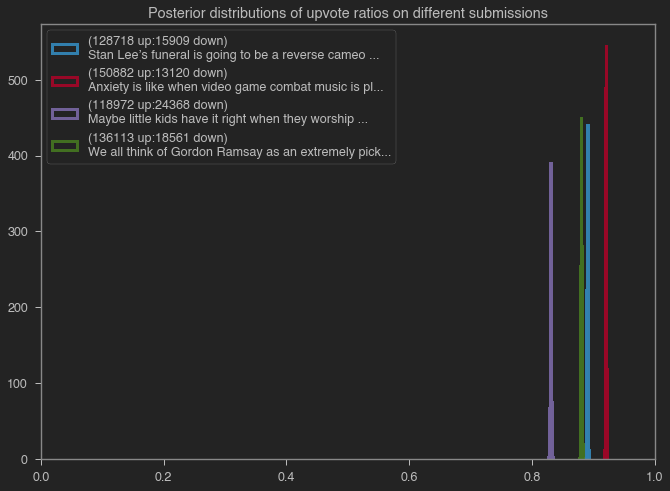

In [20]:
figsize(11., 8)

posteriors = []
colours = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457"]

for i in range(len(submissions)):
    j = submissions[i]
    posteriors.append(posterior_upvote_ratio(votes[j, 0], votes[j, 1]))
    plt.hist(posteriors[i], bins=10, density=True, alpha=.9, 
             histtype='step', color=colours[i%5], lw=3, 
             label=f'({votes[j, 0]} up: {votes[j, 1]} down)\n{contents[j][:50]}...')
    plt.hist(posteriors[i], bins=10, density=True, alpha=.05, 
             histtype='stepfilled', color=colours[i], lw=3)
    
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.title("Posterior distributions of upvote ratios on different submissions");

All are very tight, expressing our uncertainty with what the true upvote ratio might be.

### Sorting!

How do we sort the submissions from *best to worst*? Of course, we cannot sort distributions, we must sort scalar numbers. There are many ways to distill a distribution down to a scalar: expressing the distribution through its expected value, or mean, is one way. Choosing the mean is a bad choice though. This is because the mean does not take into account the uncertainty of distributions.

I  suggest using the *95% least plausible value*, defined as the value such that there is only a 5% chance the true parameter is lower (think of the lower bound on the 95% credible region). Below are the posterior distributions with the 95% least-plausible value plotted:

order: [1 0 3 2]
lower_limits: [0.8886535441631914, 0.9188927887641801, 0.8284267583153055, 0.8785963989701147]


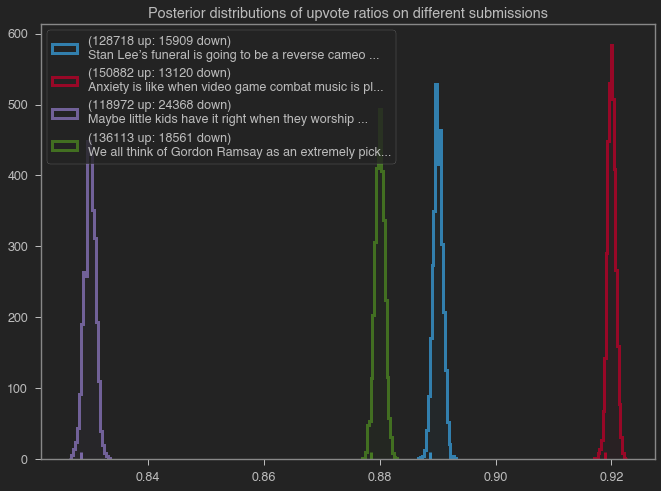

In [24]:
N = posteriors[0].shape[0]
lower_limits = []

for i in range(len(submissions)):
    j = submissions[i]
    plt.hist(posteriors[i], bins=20, density=True, alpha=.9, 
             histtype='step', color=colours[i], lw=3, 
             label=f'({votes[j, 0]} up: {votes[j, 1]} down)\n{contents[j][:50]}...')
    plt.hist(posteriors[i], bins=20, density=True, alpha=.05, 
             histtype='stepfilled', color=colours[i], lw=3)
    v = np.sort(posteriors[i])[int(.05 * N)]
    plt.vlines(v, 0, 10, color=colours[i], linestyles='--', linewidths=3)
    lower_limits.append(v)
    plt.legend(loc='upper left')
    
plt.legend(loc='upper left')
plt.title("Posterior distributions of upvote ratios on different submissions")
order = np.argsort(-np.array(lower_limits))
print(f'order: {order}')
print(f'lower_limits: {lower_limits}')

The best submissions, according to our procedure, are the submissions that are *most-likely* to score a high percentage of upvotes. Visually those are the submissions with the 95% least plausible value close to 1.

Why is sorting based on this quantity a good idea? By ordering by the 95% least plausible value, we are being the most conservative with what we think is best.  When using the lower-bound of the 95% credible interval, we believe with high certainty that the 'true upvote ratio' is at the very least equal to this value (or greater), thereby ensuring that the best submissions are still on top. Under this ordering, we impose the following very natural properties:

1. given two submissions with the same observed upvote ratio, we will assign the submission with more votes as better (since we are more confident it has a higher ratio).
2. given two submissions with the same number of votes, we still assign the submission with more upvotes as *better*.

### But this is too slow for real-time!

Computing the posterior of every submission takes a long time, and by the time you have computed it, likely the data has changed.

##### Derivation of sorting submissions formula

Basically what we are doing is using a Beta prior (with parameters $a=1, b=1$, which is a uniform distribution), and using a Binomial likelihood with observations $u, N = u+d$. This means our posterior is a Beta distribution with parameters $a' = 1 + u, b' = 1 + (N - u) = 1+d$. We then need to find the value, $x$, such that 0.05 probability is less than $x$. This is usually done by inverting the CDF ([Cumulative Distribution Function](http://en.wikipedia.org/wiki/Cumulative_Distribution_Function)), but the CDF of the beta, for integer parameters, is known but is a large sum. 

We instead use a Normal approximation. The mean of the Beta is $\mu = a'/(a'+b')$ and the variance is 

$$\sigma^2 = \frac{a'b'}{ (a' + b')^2(a'+b'+1) }$$

Hence we solve the following equation for $x$ and have an approximate lower bound. 

$$ 0.05 = \Phi\left( \frac{(x - \mu)}{\sigma}\right) $$ 

$\Phi$ being the [cumulative distribution for the normal distribution](http://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution)

One way is to use the following formula to compute the lower bound very fast.

$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 
\begin{align}
& a = 1 + u \\\\
& b = 1 + d \\\\
\end{align}

$u$ is the number of upvotes, and $d$ is the number of downvotes. The formula is a shortcut in Bayesian inference.

In [25]:
def intervals(u, d):
    a = 1. + u
    b = 1. + d
    mu = a / (a + b)
    std_err = 1.65 * np.sqrt((a * b) / ((a + b) ** 2 * (a + b + 1.)))
    return (mu, std_err)

In [26]:
print('Approximate lower bounds:')
posterior_mean, std_err = intervals(votes[:, 0], votes[:, 1])
lb = posterior_mean - std_err
print(lb)
print('\n')
print('Top 40 sorted according to approximate lower bounds:')
print('\n')
order = np.argsort(-lb)
ordered_contents = []
for i in order[:40]:
    ordered_contents.append(contents[i])
    print(votes[i, 0], votes[i, 1], contents[i])
    print('--------------')

Approximate lower bounds:
[0.95924548 0.9390764  0.92901635 0.91891531 0.91890879 0.91889766
 0.92895061 0.91889049 0.9490748  0.94907249 0.94907001 0.90883838
 0.91887345 0.93898666 0.90879693 0.92889577 0.87867497 0.94902646
 0.92888109 0.91882347 0.93894223 0.94901837 0.92887536 0.9087627
 0.90875931 0.92886806 0.9188026  0.87863095 0.91879047 0.89869885
 0.95908226 0.88865357 0.93890543 0.95907665 0.95907058 0.938896
 0.88863685 0.95906379 0.92882171 0.94897184 0.88862243 0.88861889
 0.92881746 0.90870276 0.91875029 0.838483   0.89864875 0.93887557
 0.91874712 0.87856551 0.93886889 0.89863436 0.89862895 0.94893591
 0.94893055 0.93884298 0.9187127  0.91871192 0.90865278 0.87853021
 0.89861014 0.89860715 0.95901666 0.94892039 0.87851984 0.84844046
 0.86848678 0.92876158 0.92875908 0.84842727 0.89858883 0.94891067
 0.92874957 0.91868901 0.92874728 0.82838826 0.89858128 0.90862598
 0.91867771 0.94889356 0.93880853 0.89856448 0.88852692 0.92873127
 0.90861069 0.91866613 0.93880585 0.878

We can view the ordering visually by plotting the posterior mean.

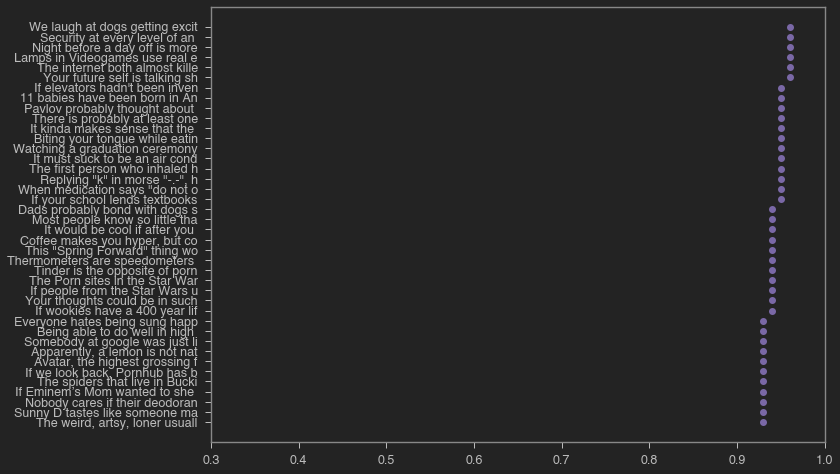

In [36]:
reversed_order = order[::-1][-40:]
plt.errorbar(posterior_mean[reversed_order], np.arange(len(reversed_order)),
             xerr=std_err[reversed_order], capsize=0, fmt='o',
             color='#7A68A6')
plt.xlim(.3, 1)
plt.yticks(np.arange(len(reversed_order) - 1, -1, -1),
           map(lambda x: x[:30].replace('\n', ''), ordered_contents));

### Extension to Starred rating systems

The above procedure works well for upvote-downvotes schemes, but what about systems that use star ratings, e.g. 5 star rating systems. Similar problems apply with simply taking the average: an item with two perfect ratings would beat an item with thousands of perfect ratings, but a single sub-perfect rating. 

We can consider the upvote-downvote problem above as binary: 0 is a downvote, 1 if an upvote. A $N$-star rating system can be seen as a more continuous version of above, and we can set $n$ stars rewarded is equivalent to rewarding $\frac{n}{N}$. For example, in a 5-star system, a 2 star rating corresponds to 0.4. A perfect rating is a 1. We can use the same formula as before, but with $a,b$ defined differently:

$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 

\begin{align}
& a = 1 + S \\\\
& b = 1 + N - S \\\\
\end{align}

where $N$ is the number of users who rated, and $S$ is the sum of all the ratings, under the equivalence scheme mentioned above. 

### How would you estimate the quantity 
$E\left[ \cos{X} \right]$, where $X \sim \text{Exp}(4)$? What about $E\left[ \cos{X} | X \lt 1\right]$, i.e. the expected value *given* we know $X$ is less than 1? Would you need more samples than the original samples size to be equally accurate?

In [38]:
exp = stats.expon(scale=4)
N = 1e5
X = exp.rvs(int(N))

In [49]:
print(f'E[cos(X)]: {np.cos(X).mean()}')

E[cos(X)]: 0.059057541862955434


In [53]:
print(f'E[cos(X) | (X) < 1]: {np.cos(X[X < 1]).mean()}')

E[cos(X) | (X) < 1]: 0.8518466060151283


2\. The following table was located in the paper "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression". The table ranks football field-goal kickers by their percent of non-misses. What mistake have the researchers made?

-----

####  Kicker Careers Ranked by Make Percentage
<table><tbody><tr><th>Rank </th><th>Kicker </th><th>Make % </th><th>Number  of Kicks</th></tr><tr><td>1 </td><td>Garrett Hartley </td><td>87.7 </td><td>57</td></tr><tr><td>2</td><td> Matt Stover </td><td>86.8 </td><td>335</td></tr><tr><td>3 </td><td>Robbie Gould </td><td>86.2 </td><td>224</td></tr><tr><td>4 </td><td>Rob Bironas </td><td>86.1 </td><td>223</td></tr><tr><td>5</td><td> Shayne Graham </td><td>85.4 </td><td>254</td></tr><tr><td>… </td><td>… </td><td>…</td><td> </td></tr><tr><td>51</td><td> Dave Rayner </td><td>72.2 </td><td>90</td></tr><tr><td>52</td><td> Nick Novak </td><td>71.9 </td><td>64</td></tr><tr><td>53 </td><td>Tim Seder </td><td>71.0 </td><td>62</td></tr><tr><td>54 </td><td>Jose Cortez </td><td>70.7</td><td> 75</td></tr><tr><td>55 </td><td>Wade Richey </td><td>66.1</td><td> 56</td></tr></tbody></table>

In August 2013, [a popular post](http://bpodgursky.wordpress.com/2013/08/21/average-income-per-programming-language/) on the average income per programmer of different languages was trending. Here's the summary chart: (reproduced without permission, cause when you lie with stats, you gunna get the hammer). What do you notice about the extremes?

------

#### Average household income by programming language

<table >
 <tr><td>Language</td><td>Average Household Income ($)</td><td>Data Points</td></tr>
 <tr><td>Puppet</td><td>87,589.29</td><td>112</td></tr>
 <tr><td>Haskell</td><td>89,973.82</td><td>191</td></tr>
 <tr><td>PHP</td><td>94,031.19</td><td>978</td></tr>
 <tr><td>CoffeeScript</td><td>94,890.80</td><td>435</td></tr>
 <tr><td>VimL</td><td>94,967.11</td><td>532</td></tr>
 <tr><td>Shell</td><td>96,930.54</td><td>979</td></tr>
 <tr><td>Lua</td><td>96,930.69</td><td>101</td></tr>
 <tr><td>Erlang</td><td>97,306.55</td><td>168</td></tr>
 <tr><td>Clojure</td><td>97,500.00</td><td>269</td></tr>
 <tr><td>Python</td><td>97,578.87</td><td>2314</td></tr>
 <tr><td>JavaScript</td><td>97,598.75</td><td>3443</td></tr>
 <tr><td>Emacs Lisp</td><td>97,774.65</td><td>355</td></tr>
 <tr><td>C#</td><td>97,823.31</td><td>665</td></tr>
 <tr><td>Ruby</td><td>98,238.74</td><td>3242</td></tr>
 <tr><td>C++</td><td>99,147.93</td><td>845</td></tr>
 <tr><td>CSS</td><td>99,881.40</td><td>527</td></tr>
 <tr><td>Perl</td><td>100,295.45</td><td>990</td></tr>
 <tr><td>C</td><td>100,766.51</td><td>2120</td></tr>
 <tr><td>Go</td><td>101,158.01</td><td>231</td></tr>
 <tr><td>Scala</td><td>101,460.91</td><td>243</td></tr>
 <tr><td>ColdFusion</td><td>101,536.70</td><td>109</td></tr>
 <tr><td>Objective-C</td><td>101,801.60</td><td>562</td></tr>
 <tr><td>Groovy</td><td>102,650.86</td><td>116</td></tr>
 <tr><td>Java</td><td>103,179.39</td><td>1402</td></tr>
 <tr><td>XSLT</td><td>106,199.19</td><td>123</td></tr>
 <tr><td>ActionScript</td><td>108,119.47</td><td>113</td></tr>
</table>

Both charts are naively sorting computed statistics (conversion in the first, and average in the second) without considering the sample sizes used to determine the statistics. This leads to problems; in the table of career kicks, Garrett Hartley is clearly not the best kicker. That honor goes to Matt Stover. In the table of salaries, the extreme salaries are both populated with languages with smaller numbers of data points. A naive (and wrong) interpretation after looking at this chart might be that companies clearly have to pay more to attract developers in the rarer languages, as there is a lower supply of developers for these languages.